# Graph Neural Networks for Recommendation Systems

In this last TP, you are going to explore the use of Graph Neural Networks (GNNs) for Recommendation Systems.

The dataset you'll use is the dataset MovieLens 100K. This dataset describes people's expressed preference for movies. Each preference is described as a tuple (user, movie, rating). 

Users and movies description are also added. On one side, users are defined by their age, sex, occupation and location. On the other side, movies are described by 19 categories, for which each movie can belong to one or more.

This TP is two-fold. First part concerns the computation and the analysis of the dataset, and will mostly be treated in TD, and second part is about the use of GNNs for movie recommendation.

## Part 1 : Dataset analysis

### Libraries to include

First of all, here are some libraries that you may need during this TP. Some of them are not mandatory, while other ones might not be used at all.

In [1]:
import math
import copy
import pickle
import glob
import os
import sys
import time
from pathlib import Path
from itertools import zip_longest
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import torch
from torch import nn
from torch import optim

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'



#____________________________________________________________

!pip install gdown
!gdown 1a7ZViLBLoCHKuLP8CSP_5uj0CTABqDaQ
!mkdir ml-100k
!tar -xvf  'ml-100k.tar.xz' -C 'ml-100k'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1a7ZViLBLoCHKuLP8CSP_5uj0CTABqDaQ
To: /content/ml-100k.tar.xz
100% 710k/710k [00:00<00:00, 109MB/s]
u.data
u.item
u.user


### Setting the random seeds
Used in order to fix the randomness of the experiments. It will be probably useless here, but it is always prefered.

In [2]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 2021
set_random_seed(RANDOM_STATE)

### Read the dataset files using pandas

You start to work here ! First of all, we need to read the data. For this, we are going to use pandas. We also use this stage to remove the unused fields.

The unused fields are : 
- timestamp in ratings
- movieId, movie title, release data, video release date and IMDb URL for movies
- user id and zip code for users

We also use this stage to ont hot encode and normalize our data. Movies categories are already one hot encoded, so we only need to encode the sex and occupation fields. For normalization, we'll normalize the age field.

In [3]:
import pandas as pd
from pathlib import Path

def read_data(path):
    files = {}
    path = Path(path)
    for filename in path.glob('*'):
        if filename.suffix == '.data': 
            if filename.stem == 'u':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
                data = pd.read_csv(filename, sep='\t', names=columns, engine='python', encoding='latin-1')
                data.drop(columns="timestamp", inplace=True)

                files['ratings'] = data
                
        elif filename.suffix == '.item': 
            if filename.stem == 'u':
                columns = ['movieId', 'title', 'releaseDate', 'videoReleaseDate', 'imdbUrl', 
                           'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 
                           'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
                           'Thriller', 'War', 'Western']
                data = pd.read_csv(filename, sep='|', names=columns, engine='python', encoding='latin-1')
                data.drop(columns=columns[:5], inplace=True)
                files['movies'] = data
                
        elif filename.suffix == '.user': 
            if filename.stem == 'u':
                columns = ['userId', 'age', 'gender', 'occupation', 'zipCode']
                data = pd.read_csv(filename, sep='|', names=columns, engine='python', encoding='latin-1')
                # One-hot encode gender field
                gender_encoded = pd.get_dummies(data['gender'], prefix='gender')
                
                # One-hot encode occupation field
                occupation_encoded = pd.get_dummies(data['occupation'], prefix='occupation')
                
                # Concatenate the encoded fields with the original dataframe
                data_encoded = pd.concat([data['age'], gender_encoded, occupation_encoded], axis=1)
                
                # Min-max normalize age field
                data_encoded['age'] = (data_encoded['age'] - data_encoded['age'].min()) / (data_encoded['age'].max() - data_encoded['age'].min())

                data.drop(columns=["userId",'zipCode'], inplace=True)
                files['users'] = data_encoded
                
    return files['ratings'], files['movies'], files['users']

dataset = 'ml-100k'
ratings, movies, users = read_data(dataset)


We can check what our ratings looks like : 

In [4]:
ratings.head()

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


We can do the same for movies and users

In [5]:
movies.head()

,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
users.head()

,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0.257576,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.696970,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.242424,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.257576,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.393939,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Analysis

Let's take some time to analyze a bit our dataset. We can for example plot the the histogram of ratings. What do you observe ? 

<Axes: >

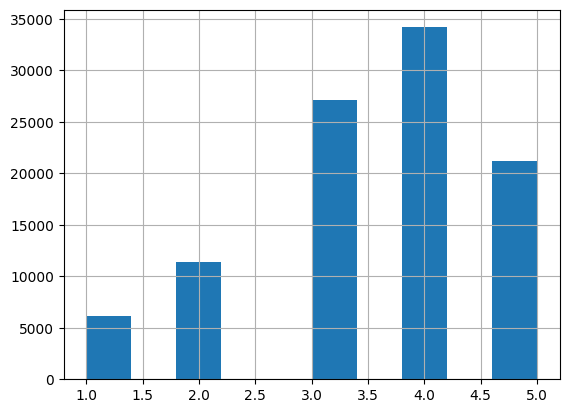

In [7]:
ratings["rating"].hist()

__Plot the different features and analyse them.__

<Axes: >

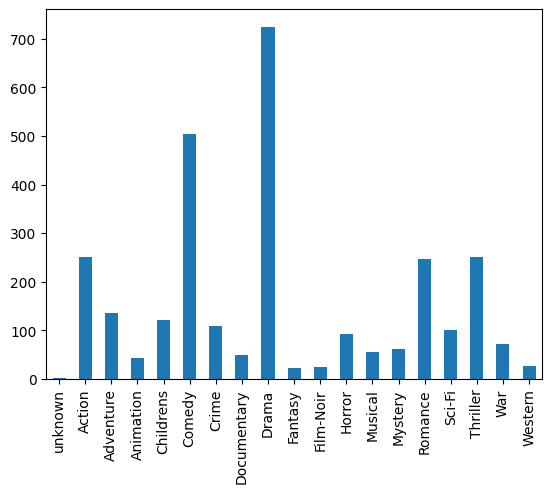

In [8]:
movies.sum().plot.bar()

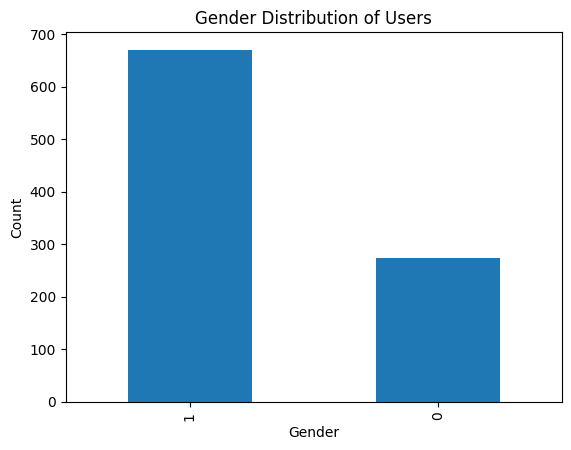

In [9]:
colors = ['#FF69B4', '#6495ED']

# Plot histogram
users['gender_F'].value_counts().plot(kind='bar')
users['gender_M'].value_counts().plot(kind='bar')

# Set title, x-axis label, and y-axis label
plt.title('Gender Distribution of Users')
plt.xlabel('Gender')
plt.ylabel('Count')


# Display plot
plt.show()


In [11]:
users.shape

(943, 24)

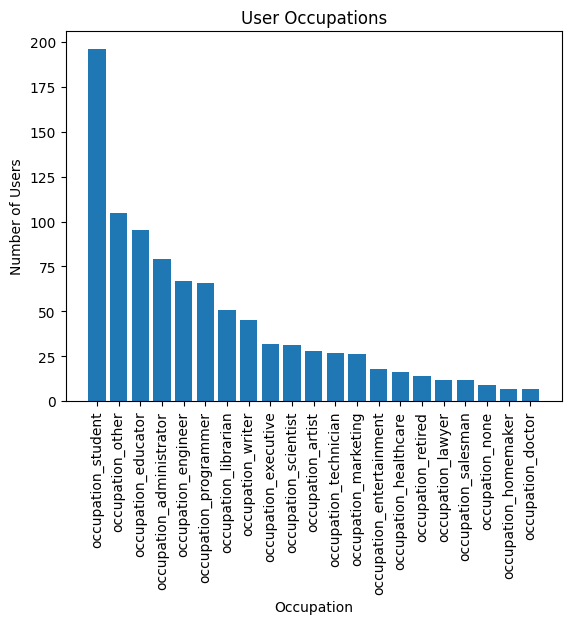

In [13]:
# TO DO : plot the histogram for the users occupation
# Get the one-hot encoded columns for user occupations
occupation_cols = users.columns[3:]

# Count the number of users in each occupation category
occupation_counts = users[occupation_cols].sum().sort_values(ascending=False)

# Create a bar plot of the occupation counts
plt.bar(occupation_counts.index, occupation_counts.values)

# Set the title and axis labels
plt.title('User Occupations')
plt.xlabel('Occupation')
plt.ylabel('Number of Users')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


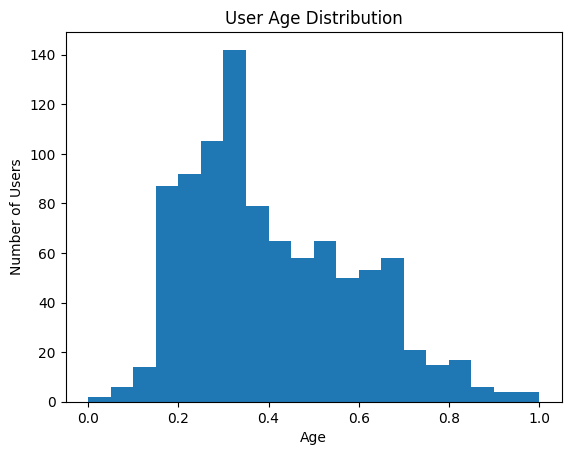

In [14]:
# TO DO : plot the histogram for the users age

# Plot the histogram
plt.hist(users['age'], bins=20)
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()


__Comment the different results you obtain. What kind of biases can you see ? How do you think those biases may perturb your model ? Do you think AI algorithms used also have biases ?__ 


<font color='red'>When we plot the histograms of users' gender, occupation, and age, we can observe some biases in the data. For example:

<font color='red'>Gender bias: The user gender histogram shows that the dataset is heavily biased towards male users, with around twice as many male users as female users. This gender bias can potentially impact the performance of our recommendation model since it may result in less accurate recommendations for female users.

<font color='red'>Occupation bias: The user occupation histogram shows that most users in the dataset are students, followed by other common occupations such as educators, administrators, and engineers. However, some occupations such as homemakers, artists, and retired individuals are underrepresented in the dataset. This occupation bias may affect the performance of our model for underrepresented occupations.

Age bias: The user age histogram shows that most users in the dataset are in the age range of 18-35, with fewer users in older age groups. This age bias may affect the performance of our model for older users who may have different movie preferences than younger users.</font> 

## Part 2 : Preparing the dataset 

No more analysis, now we want to apply machine learning models to recommend movies according to this dataset.

First step is to prepare the dataset in order to make it usable by our models.

The following function take the triples from ratings and convert it into X and y, where X are the pair user/movie, and y is the rating to predict.

__Question : why did we modify the user index ?__


In [15]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()

    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)

    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)

    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

(n, m), (X, y), _ = create_dataset(ratings)
print(X.head())
print("_____________")
print(y.head())
print("_____________")
print(f'Embeddings: {n} users, {m} movies')
print("_____________")
print(f'Dataset shape: {X.shape}')
print("_____________")
print(f'Target shape: {y.shape}')

   user_id  movie_id
0        0         0
1        1         1
2        2         2
3        3         3
4        4         4
_____________
0    3.0
1    3.0
2    1.0
3    2.0
4    1.0
Name: rating, dtype: float32
_____________
Embeddings: 943 users, 1682 movies
_____________
Dataset shape: (100000, 2)
_____________
Target shape: (100000,)


Now, we have to separate our dataset into 3 parts : train, valid and test. By using the train_test_split() function from sklearn.model_selection, put 60% of the data in training, 20% of the data for validation, and 20% in test.

Hint : the function divide the input into 2 splits...

__Due to the number of entries, you might need to reduce the number of data in training and validation later (personnaly, i have 20% in train and 16% in valid).__

In [16]:
# TO DO : split the datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid), 'test': (X_test, y_test)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid), 'test': len(X_test)}
print(X.shape)
print(X_train.shape)
print(dataset_sizes)

(100000, 2)
(60000, 2)
{'train': 60000, 'val': 20000, 'test': 20000}


Now we have our train, valid and test data, we need to compute the nodes of our graph. 

Here, our graph is a bit particular. It is a bipartite graph, where each part represent different entities (users and movies). In order to allow our models to differentiate users and movies, we'll add a new feature, which is going to be 0 if the node is a user, and 1 if the node is a movie. 

We end up by concatenating both matrices into a single one, our node matrix (H in the course)

In [17]:
print(X.shape)
print(users.shape)

(100000, 2)
(943, 24)


In [43]:
def compute_nodes(users, movies):
    # Add node type column to users and movies dataframes
    users['node_type'] = 0
    movies['node_type'] = 1

    # Concatenate users and movies dataframes into a single dataframe
    nodes = pd.concat([users, movies], ignore_index=True)
    nodes.fillna(0, inplace=True)
    
    return nodes.to_numpy()



nodes = compute_nodes(users, movies)

print(nodes)
print("_____________")
print(f'Node matrix shape: {nodes.shape}')


[[0.25757576 0.         1.         ... 0.         0.         0.        ]
 [0.6969697  1.         0.         ... 0.         0.         0.        ]
 [0.24242424 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
_____________
Node matrix shape: (2625, 44)


We also compute the corresponding adjacency matrix.

__Question : why do we only use X_train to compute the adjacency matrix ?__

In [52]:
import scipy.sparse as sp

def compute_adjacency_matrix(X_train):
    
    user_idx, movie_idx = X_train['user_id'], X_train['movie_id']
    
    n_users, n_movies = user_idx.max()+1, movie_idx.max()+1
    
    # Create empty adjacency matrix
    adj = np.zeros((n_users+n_movies, n_users+n_movies))
    
    # Fill in the edges
    adj[user_idx, n_users+movie_idx] = 1
    adj[n_users+movie_idx, user_idx] = 1
    
    # Square the adjacency matrix
    #adj_squared = np.dot(adj, adj)
    
    return adj




adjacency_matrix = compute_adjacency_matrix(X_train)
full_adj = compute_adjacency_matrix(X)


__By using matplotlib, plot both adjacency_matrix. What do you observe ?__

Once it is done, we won't use full_adj anymore

In [45]:
print(adjacency_matrix.shape)

(2625, 2625)


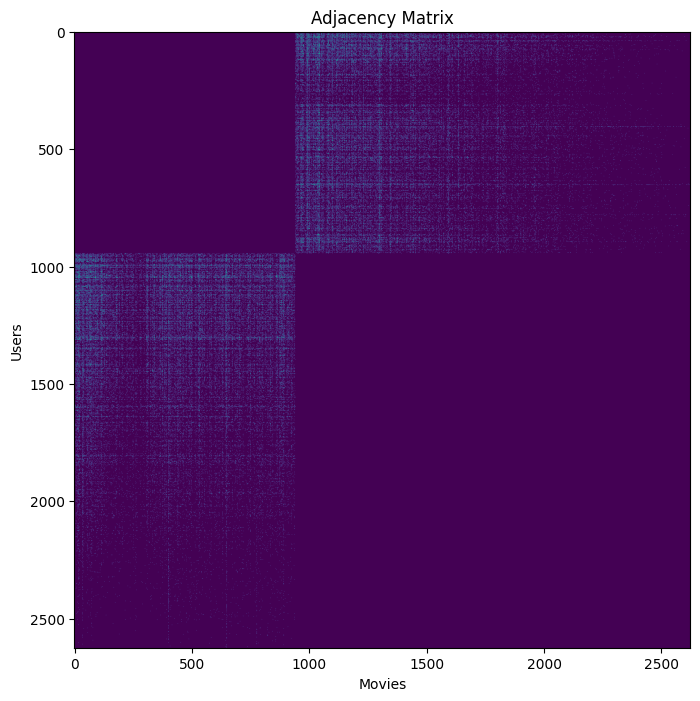

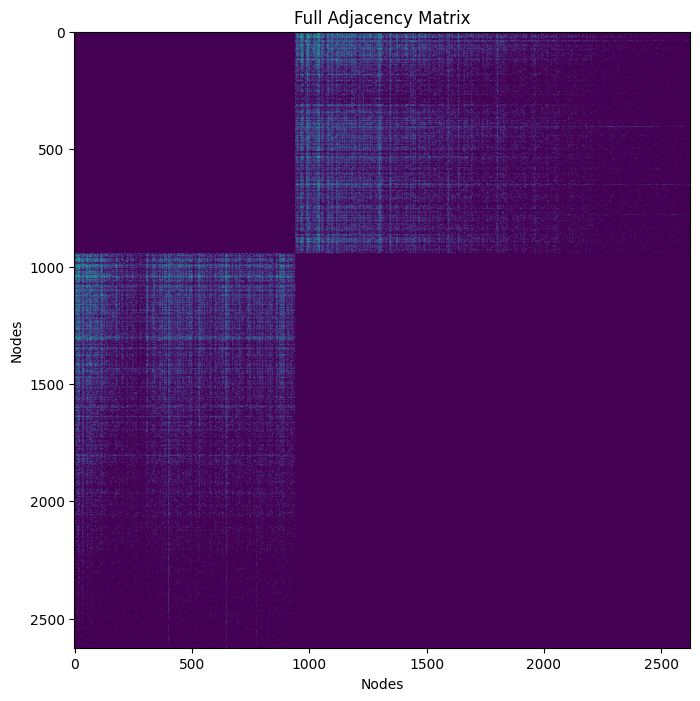

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(adjacency_matrix)
plt.title("Adjacency Matrix")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(full_adj)
plt.title("Full Adjacency Matrix")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()


## Part 3 : Training section

We now have almost everything we need to train our model. First thing is to convert X_train, y_train, X_valid, y_valid, X_test and y_test into tensors (your job)

In [23]:
# TO DO : Transform your data into Tensors
# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

Next step is to define a GNN Layer. Complete the following code in order to compute a simple GNN layer \sigma(AHW+b)

In [53]:
class GNN_layer(nn.Module):
    def __init__(self, input_dim, output_dim=64):
        super(GNN_layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()#relu delivers better rsme
        #self.activation = nn.Sigmoid()
    def forward(self, nodes, adjacency):
        # Compute AH multiplication
        ah = torch.sparse.mm(adjacency,nodes)
        
       # Apply Linear layer and non-linearity
        out = self.linear(ah)
        out = self.activation(out)
        
        return out


We now define our model. This model takes as input the nodes, the adjacency matrix, and the list of pair to predict X_(train/valid/test). It returns a value for each pair to predict. 

Complete the model in order to use one gnn layer you previously computed, and one linear layer to predict for each pair. 

In [54]:
class GNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_model, self).__init__()
        # TO DO
        # Attributes : intput dim, hidden dim (and output dim ?)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Add a GNN layer
        self.gnn_layer = GNN_layer(input_dim, hidden_dim)
        
        # Decision layer. Do we need an activation function ? If not, why ? If yes, which one ?
        self.linear_layer = nn.Linear(2*self.hidden_dim, output_dim)
        self.activation = nn.ReLU()
        #self.activation = nn.Sigmoid() 
    def forward(self, nodes, adjacency, X):
        # TO DO 
        # Apply GNN layer
        out = self.gnn_layer(nodes, adjacency)
        # Concatenate each pair of features for X.
        node_pair = nodes[X].reshape((X.shape[0], 2*self.hidden_dim))
  
        # Apply decision layer
        out = self.linear_layer(node_pair)
        out = self.activation(out)
        
        
        return out

        

Time to train ! Start by transforming the adjacency matrix and the nodes matrix into tensors.

Then, at each eapoch, make one step of training, and one step of validation, and save both losses into lists, in order to plot the training curves.

100%|██████████| 1000/1000 [01:16<00:00, 13.08it/s]


Test RMSE: 1.1455892324447632
Test Predictions: [3.3292506 3.555084  3.4830103 ... 3.4170547 3.256069  3.105797 ]


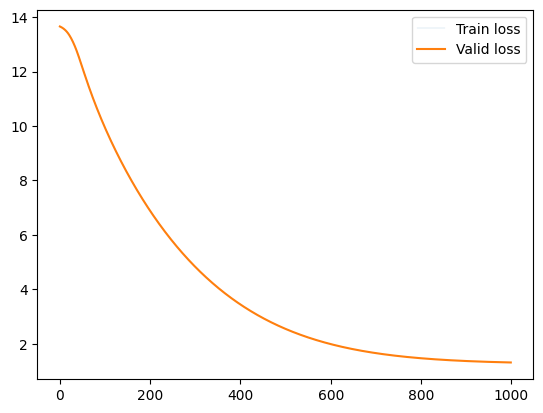

In [64]:
nb_epochs = 1000
learning_rate = 1e-3

loss_train = []
loss_valid = []

nodes_tensor = torch.from_numpy(nodes).float().to(device)
adjacency_matrix_tensor = torch.from_numpy(adjacency_matrix).float().to(device)
model = GNN_model(input_dim=nodes.shape[1], hidden_dim=nodes.shape[1], output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for i in tqdm(range(nb_epochs)):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(nodes_tensor, adjacency_matrix_tensor, X_train_tensor)
    loss = criterion(out, y_train_tensor.unsqueeze(1).float().to(device))
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(nodes_tensor, adjacency_matrix_tensor, X_valid_tensor)
        loss = criterion(out, y_valid_tensor.unsqueeze(1).float().to(device))
        loss_valid.append(loss.item())

# Test
model.eval()
with torch.no_grad():
    out = model(nodes_tensor, adjacency_matrix_tensor, X_test_tensor)
    mse = criterion(out, y_test_tensor.unsqueeze(1).float().to(device))
    rmse = torch.sqrt(mse).item()
    print('Test RMSE:', rmse)

# Printing the test predictions
test_predictions = out.cpu().detach().numpy().flatten()
print('Test Predictions:', test_predictions)
# Plot
plt.rcParams.update(plt.rcParamsDefault)

plt.plot(loss_train, label='Train loss',linewidth=3)
plt.plot(loss_valid, label='Valid loss')
plt.legend()
plt.show()

del model


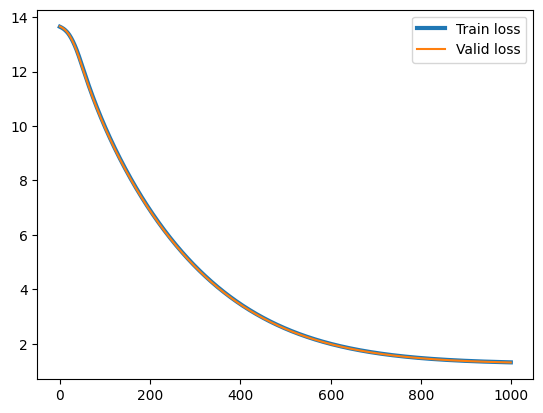

In [65]:

plt.plot(loss_train, label='Train loss',linewidth=3)
plt.plot(loss_valid, label='Valid loss')
plt.legend()
plt.show()

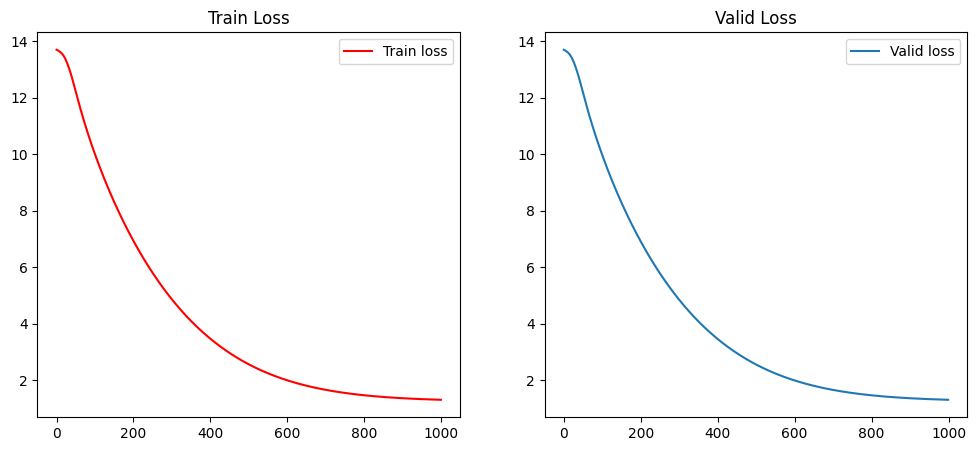

0.0036808252334594727


In [61]:

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot train loss on the first subplot
ax1.plot(loss_train, label='Train loss', color='red')
ax1.set_title('Train Loss')
ax1.legend()

# Plot valid loss on the second subplot
ax2.plot(loss_valid, label='Valid loss')
ax2.set_title('Valid Loss')
ax2.legend()

plt.show()
print(loss_train[1]-loss_valid[1])

We now ant to improve our GNN model into a Vanilla GNN \sigma((A+I)HW). No need to change our layer, we only need to change our adjacency matrix ! 

100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


Test RMSE: 1.1487300395965576


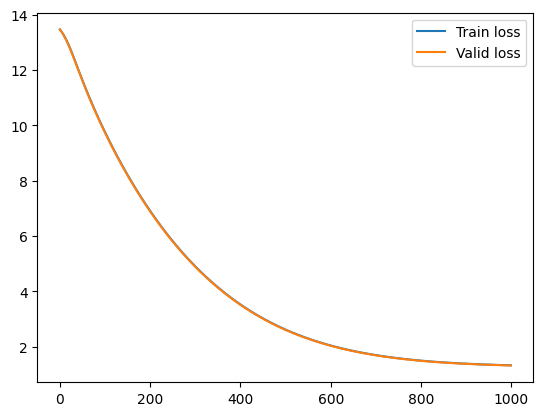

In [27]:
nb_epochs = 1000
learning_rate = 1e-3

loss_train = []
loss_valid = []




# Create the identity matrix with shape (n_nodes, n_nodes)
identity_matrix = np.identity(adjacency_matrix.shape[0])

# Add the identity matrix to the adjacency matrix
adjacency_matrix = adjacency_matrix + identity_matrix
nodes_tensor = torch.from_numpy(nodes).float().to(device)
adjacency_matrix_tensor = torch.from_numpy(adjacency_matrix).float().to(device)

model = GNN_model(input_dim=nodes.shape[1], hidden_dim=44, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for i in tqdm(range(nb_epochs)):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(nodes_tensor, adjacency_matrix_tensor, X_train_tensor)
    loss = criterion(out, y_train_tensor.unsqueeze(1).float().to(device))
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(nodes_tensor, adjacency_matrix_tensor, X_valid_tensor)
        loss = criterion(out, y_valid_tensor.unsqueeze(1).float().to(device))
        loss_valid.append(loss.item())

# Test
model.eval()
with torch.no_grad():
    out = model(nodes_tensor, adjacency_matrix_tensor, X_test_tensor)
    mse = criterion(out, y_test_tensor.unsqueeze(1).float().to(device))
    rmse = torch.sqrt(mse).item()
    print('Test RMSE:', rmse)

# Plot
plt.plot(loss_train, label='Train loss')
plt.plot(loss_valid, label='Valid loss')
plt.legend()
plt.show()

del model

Finally, we want to implement the General GNN. This time, we have to modify our GNN layer in order to compute 2 linear layer : one for the adjacency matrix, and one for the identity matrix.

In [28]:
class GNN_layer_general(nn.Module):
    def __init__(self, input_dim, output_dim=64): 
        super(GNN_layer_general, self).__init__()
        
        # Attributes
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Non-linearity
        self.activation = nn.ReLU()
        
        # Layers
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(input_dim, output_dim)
        
    def forward(self, nodes, adjacency):
        # Compute general GNN
        ahw1 = torch.mm(adjacency, self.linear1(nodes))
        ihw2 = self.linear2(nodes)
        out = ahw1 + ihw2
        out = self.activation(out)
        
        return out

In [29]:
import torch
import torch.nn as nn

class GNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_model, self).__init__()
        
        # Attributes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # GNN layer
        self.gnn_layer = GNN_layer_general(input_dim, hidden_dim)
        
        # Out layer
        self.out_layer = nn.Linear(2*hidden_dim, output_dim)
        
    def forward(self, nodes, adjacency, X):
        # Apply GNN layer
        h = self.gnn_layer(nodes, adjacency)
        
        # Concatenate each pair of features for X
        node_pair = nodes[X].reshape((X.shape[0], 2*self.hidden_dim))
        
        # Apply decision layer
        out = self.out_layer(node_pair)
        
        return out



100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


Test RMSE: 1.163894772529602
Test Predictions: [3.307216  3.5340152 3.4075785 ... 3.2326648 3.2927337 3.1079586]


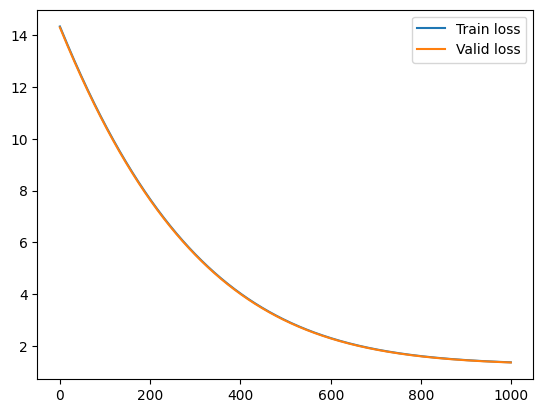

In [30]:
nb_epochs = 1000
learning_rate = 1e-3

loss_train = []
loss_valid = []

nodes_tensor = torch.from_numpy(nodes).float().to(device)
adjacency_matrix_tensor = torch.from_numpy(adjacency_matrix).float().to(device)
model = GNN_model(input_dim=nodes.shape[1], hidden_dim=44, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for i in tqdm(range(nb_epochs)):
    # Train
    model.train()
    optimizer.zero_grad()
    out = model(nodes_tensor, adjacency_matrix_tensor, X_train_tensor)
    loss = criterion(out, y_train_tensor.unsqueeze(1).float().to(device))
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        out = model(nodes_tensor, adjacency_matrix_tensor, X_valid_tensor)
        loss = criterion(out, y_valid_tensor.unsqueeze(1).float().to(device))
        loss_valid.append(loss.item())

# Test
model.eval()
with torch.no_grad():
    out = model(nodes_tensor, adjacency_matrix_tensor, X_test_tensor)
    mse = criterion(out, y_test_tensor.unsqueeze(1).float().to(device))
    rmse = torch.sqrt(mse).item()
    print('Test RMSE:', rmse)

# Printing the test predictions
test_predictions = out.cpu().detach().numpy().flatten()
print('Test Predictions:', test_predictions)
# Plot

plt.plot(loss_train, label='Train loss')
plt.plot(loss_valid, label='Valid loss')
plt.legend()
plt.show()

del model


__The end__
